In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler


###GRU (Gated Recurrent Unit) is a simplified version of LSTM that retains long-term memory with fewer gates, making it faster and more efficient. GRUs work well in time series and sequential data, especially when computation or training time is a constraint.

In this project, I’ll use a GRU to model and predict the next day’s stock price based on the last 30 days of prices.


In [2]:
# 1. Load stock data
df = yf.download("NVD.F", start="2023-01-01", end="2025-06-16")
data = df["Close"].values.reshape(-1, 1)

<ipython-input-2-716722399>:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("NVD.F", start="2023-01-01", end="2025-06-16")
[*********************100%***********************]  1 of 1 completed


In [3]:
#Normalise and create sequences
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X_train, y_train = torch.FloatTensor(X), torch.FloatTensor(y)

In [4]:
#Define GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

model = GRUModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
#Train the model
epochs = 30
for epoch in range(epochs):
    model.train()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

Epoch 1, Loss: 0.549837
Epoch 2, Loss: 0.520687
Epoch 3, Loss: 0.492798
Epoch 4, Loss: 0.466123
Epoch 5, Loss: 0.440618
Epoch 6, Loss: 0.416219
Epoch 7, Loss: 0.392849
Epoch 8, Loss: 0.370421
Epoch 9, Loss: 0.348847
Epoch 10, Loss: 0.328040
Epoch 11, Loss: 0.307923
Epoch 12, Loss: 0.288423
Epoch 13, Loss: 0.269480
Epoch 14, Loss: 0.251038
Epoch 15, Loss: 0.233058
Epoch 16, Loss: 0.215510
Epoch 17, Loss: 0.198376
Epoch 18, Loss: 0.181656
Epoch 19, Loss: 0.165360
Epoch 20, Loss: 0.149518
Epoch 21, Loss: 0.134176
Epoch 22, Loss: 0.119399
Epoch 23, Loss: 0.105276
Epoch 24, Loss: 0.091921
Epoch 25, Loss: 0.079479
Epoch 26, Loss: 0.068126
Epoch 27, Loss: 0.058072
Epoch 28, Loss: 0.049561
Epoch 29, Loss: 0.042853
Epoch 30, Loss: 0.038201


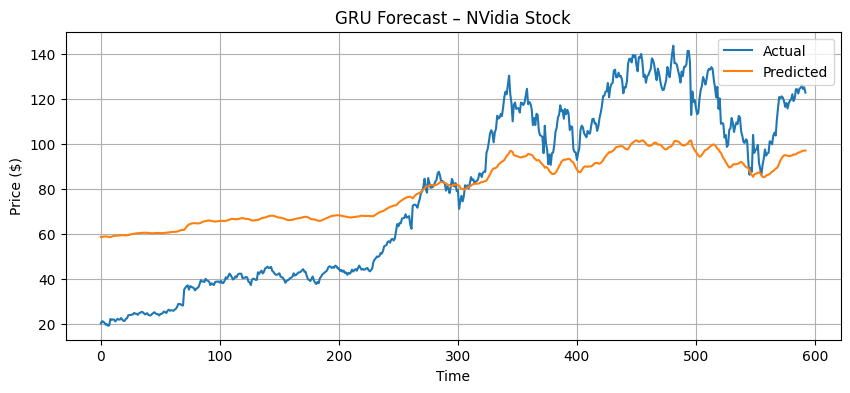

In [7]:
#Predict and plot results
model.eval()
predicted = model(X_train).detach().numpy()
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_train)

plt.figure(figsize=(10, 4))
plt.plot(actual_prices, label="Actual")
plt.plot(predicted_prices, label="Predicted")
plt.title("GRU Forecast – NVidia Stock")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()